# Smart Traffic Management System
## Introduction
Smart Traffic Management System is a system that helps to manage traffic in a smart way.In this project, roads are modeled as undirected edges for simplicity, assuming two-way traffic with symmetric congestion. In real-world deployment, a directed graph (nx.DiGraph) would be used to model one-way roads and direction-specific traffic patterns.

In [22]:
!pip install networkx matplotlib pandas
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


with open('data/city_map.json', 'r') as f:
    city_data = json.load(f)

NODES = city_data['nodes']
EDGES = city_data['edges']


In [24]:
def build_graph(case_csv):
    traffic_df = pd.read_csv(case_csv)
    traffic_map = dict(zip(traffic_df['road'], traffic_df['traffic_multiplier']))

    G = nx.Graph()
    G.add_nodes_from(NODES)

    for edge in EDGES:
        u = edge['from']
        v = edge['to']
        base_cost = edge['base_cost']
        road = f"{u}-{v}" if f"{u}-{v}" in traffic_map else f"{v}-{u}"
        multiplier = traffic_map.get(road, 1.0)
        total_cost = base_cost * multiplier

        G.add_edge(u, v,
                   weight=total_cost,
                   base_cost=base_cost,
                   multiplier=multiplier,
                   label=f"{base_cost}×{round(multiplier, 2)}={round(total_cost, 2)}"
        )
    return G

In [25]:
def visualize_traffic_case(G, case_title):
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='peachpuff', node_size=700, font_size=14, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(case_title, fontsize=16)
    plt.axis('off')
    plt.show()

In [27]:
import heapq

def dijkstra_manual(G, start, end):
    dist = {node: float('inf') for node in G.nodes}
    prev = {node: None for node in G.nodes}
    dist[start] = 0

    heap = [(0, start)]
    visited = set()

    while heap:
        current_cost, node = heapq.heappop(heap)
        if node in visited:
            continue
        visited.add(node)

        if node == end:
            break 

        for neighbor in G.neighbors(node):
            path_cost = current_cost + G[node][neighbor]['weight']
            if path_cost < dist[neighbor]:
                dist[neighbor] = path_cost
                prev[neighbor] = node
                heapq.heappush(heap, (path_cost, neighbor))

    
    path = []
    current = end
    if prev[current] is not None or current == start:
        while current:
            path.insert(0, current)
            current = prev[current]

    if not path or path[0] != start:
        return None, float('inf')  

    return path, dist[end]


In [28]:
def visualize_shortest_path(G, path, case_title):
    pos = nx.spring_layout(G, seed=42)
    
    
    path_edges = {(path[i], path[i+1]) for i in range(len(path)-1)}
    edge_colors = ['red' if (u, v) in path_edges or (v, u) in path_edges else 'gray' for u, v in G.edges()]
    
    plt.figure(figsize=(8, 4))
    nx.draw(G, pos, with_labels=True, node_color='peachpuff', node_size=700, font_size=14, font_weight='bold', edge_color=edge_colors, width=2)
    
    
    edge_labels = {(u, v): f"{G[u][v]['weight']}" for u, v in path_edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=12)
    
    plt.title(f"Shortest Path with Edge Weights: {case_title}", fontsize=16)
    plt.axis('off')
    plt.show()

In [29]:
def optimize_light_timings_dp(incoming, cycle_time=120, min_green=5, time_step=5, max_fraction=0.6):
    roads = list(incoming.items()) 
    n = len(roads)
    max_blocks = cycle_time // time_step
    min_blocks = min_green // time_step
    max_per_road_blocks = int(max_fraction * max_blocks)

    
    dp = [[-1] * (max_blocks + 1) for _ in range(n + 1)]
    choice = [[-1] * (max_blocks + 1) for _ in range(n + 1)]
    dp[0][0] = 0 

    
    for i in range(1, n + 1):
        w = roads[i - 1][1]
        for t in range(max_blocks + 1):
            for g in range(min_blocks, min(max_blocks + 1, max_per_road_blocks + 1)):
                if t - g >= 0 and dp[i - 1][t - g] != -1:
                    score = dp[i - 1][t - g] + w * g
                    if score > dp[i][t]:
                        dp[i][t] = score
                        choice[i][t] = g

    
    total_blocks = max_blocks
    timings = {}
    for i in range(n, 0, -1):
        g = choice[i][total_blocks]
        if g == -1:
            g = min_blocks 
        node = roads[i - 1][0]
        timings[node] = g * time_step
        total_blocks -= g

    return timings


In [30]:
def generate_traffic_light_timings(G, cycle_time=120, min_green=5):
    timings = {}

    for node in G.nodes:
        incoming = {}
        for neighbor in G.neighbors(node):
            if node in G[neighbor]:
                incoming[neighbor] = G[neighbor][node]['weight']
            elif neighbor in G[node]:
                incoming[neighbor] = G[node][neighbor]['weight']

        if not incoming:
            continue

        
        optimized = optimize_light_timings_dp(incoming, cycle_time=cycle_time, min_green=min_green)

        timings[node] = {f"{k}→{node}": t for k, t in optimized.items()}

    return timings

In [31]:
def print_traffic_light_timings(timings, title):
    print(f"\nTraffic Light Timings — {title}")
    print("=" * 60)
    
    for intersection, lights in timings.items():
        print(f"\n Intersection {intersection}:")
        total_time = 0
        for direction, seconds in sorted(lights.items(), key=lambda x: -x[1]):
            print(f"  → {direction.ljust(10)}: {str(seconds).rjust(3)} seconds green")
            total_time += seconds
        print(f"  Total Cycle Time: {total_time} seconds")
        print("-" * 60)

In [32]:
def analyze_case(case_csv, case_name, start="A", end="F"):
    print(f"\n{'#'*60}\nAnalyzing: {case_name}\n{'#'*60}")
    
    
    G = build_graph(case_csv)
    visualize_traffic_case(G, f"{case_name} - Traffic Conditions")
    
   
    path, cost = dijkstra_manual(G, start, end)
    if path:
        print(f"\n Shortest Path ({start}→{end}): {' → '.join(path)}")
        print(f" Total Cost: {cost}\n")
        visualize_shortest_path(G, path, case_name)
    else:
        print("No available path found.")
    
   
    timings = generate_traffic_light_timings(G)
    print_traffic_light_timings(timings, case_name)


############################################################
Analyzing: Case 1: Basic Light Traffic
############################################################


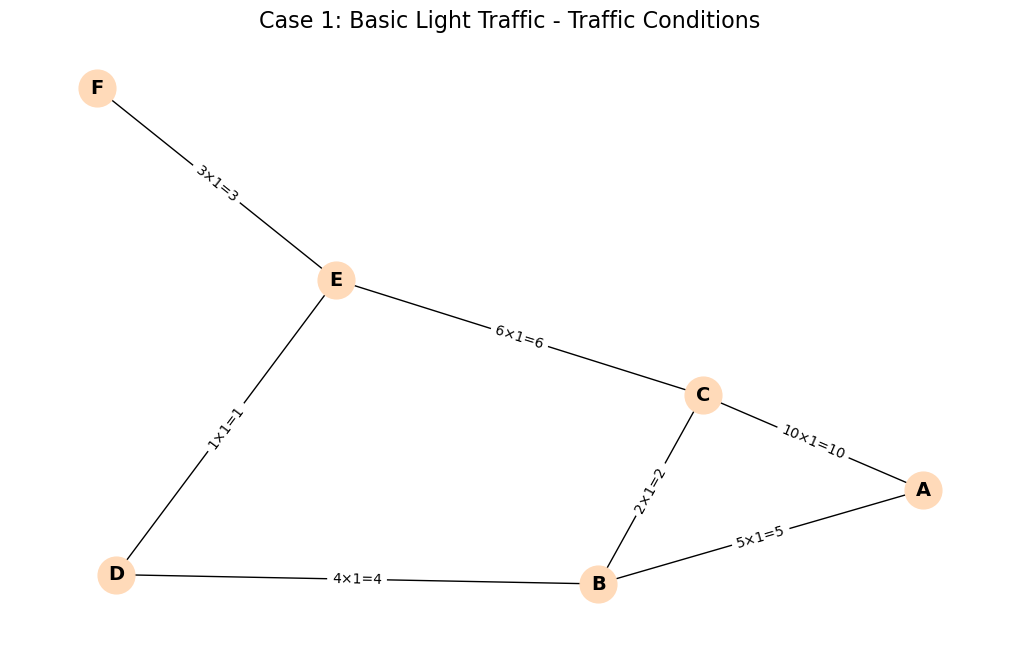


 Shortest Path (A→F): A → B → D → E → F
 Total Cost: 13



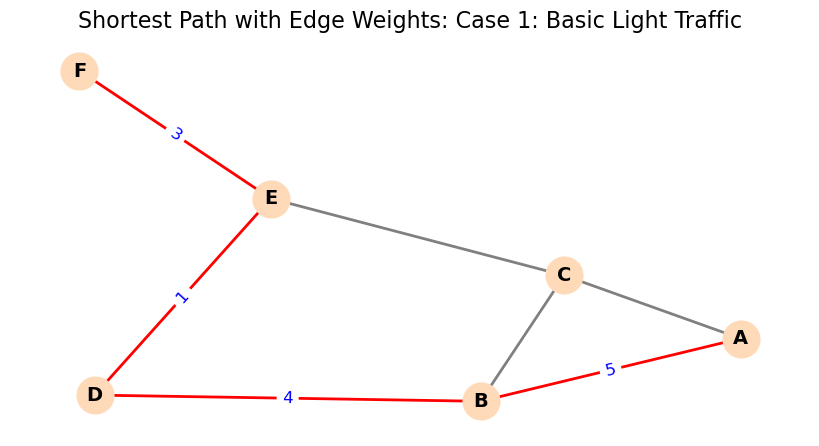


Traffic Light Timings — Case 1: Basic Light Traffic

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → A→B       :  70 seconds green
  → D→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection E:
  → C→E       :  70 seconds green
  → F→E       :  45 seconds green
  → D→E       :   5 seconds green
  Total Cycle Time: 120 seconds
-----------

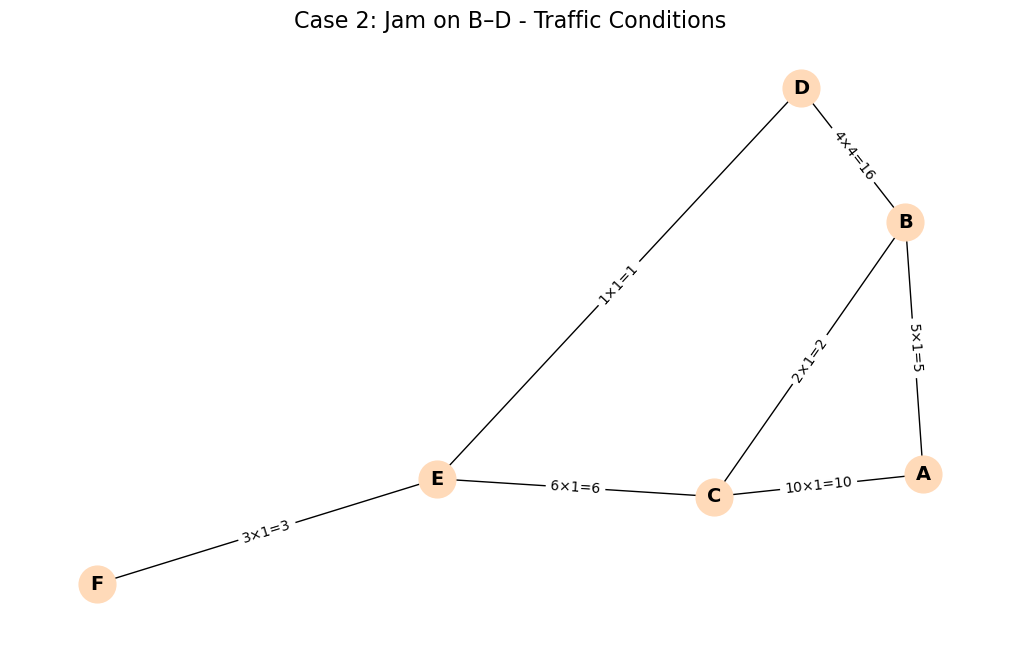


 Shortest Path (A→F): A → B → C → E → F
 Total Cost: 16



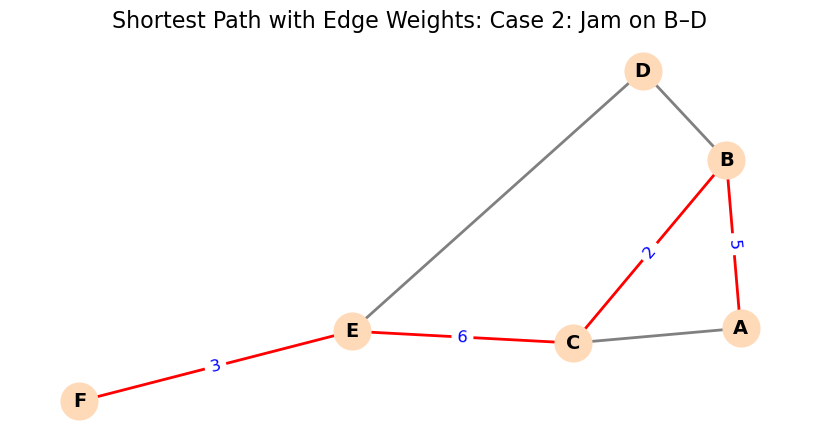


Traffic Light Timings — Case 2: Jam on B–D

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → D→B       :  70 seconds green
  → A→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection E:
  → C→E       :  70 seconds green
  → F→E       :  45 seconds green
  → D→E       :   5 seconds green
  Total Cycle Time: 120 seconds
--------------------

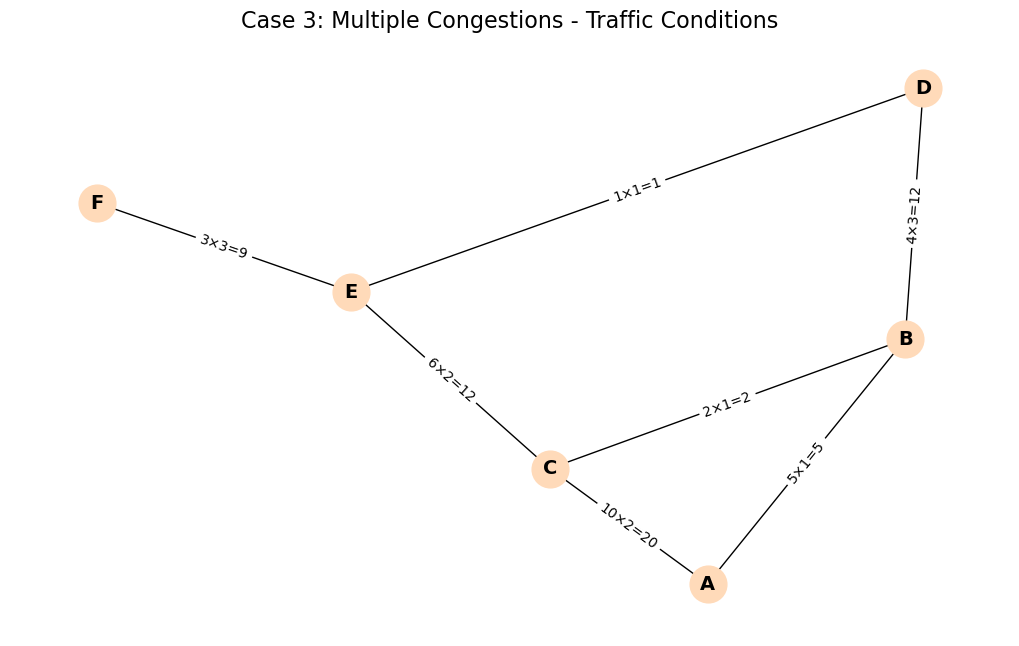


 Shortest Path (A→F): A → B → D → E → F
 Total Cost: 27



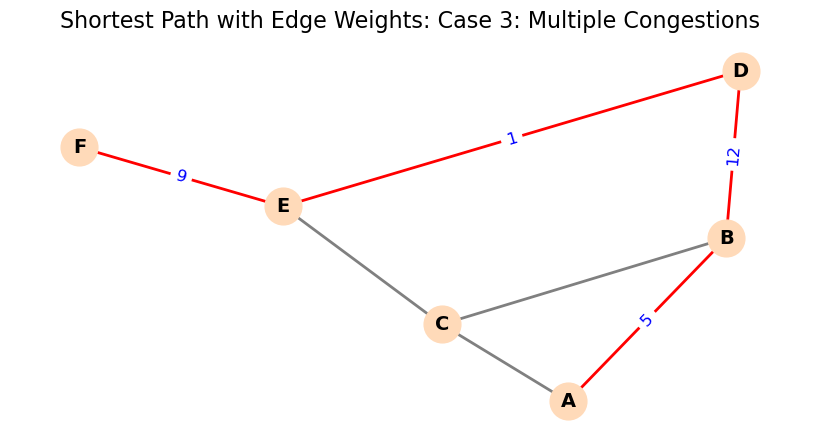


Traffic Light Timings — Case 3: Multiple Congestions

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → D→B       :  70 seconds green
  → A→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection E:
  → C→E       :  70 seconds green
  → F→E       :  45 seconds green
  → D→E       :   5 seconds green
  Total Cycle Time: 120 seconds
----------

In [33]:
analyze_case("data/traffic_data_case1.csv", "Case 1: Basic Light Traffic")
analyze_case("data/traffic_data_case2.csv", "Case 2: Jam on B–D")
analyze_case("data/traffic_data_case3.csv", "Case 3: Multiple Congestions")

In [46]:
def greedy_vehicle_routing(case_csv, start_nodes, end_node, base_multiplier=1.0, step=0.2, max_multiplier=3.0):
    G = build_graph(case_csv)
    results = []

    for start in start_nodes:
        path, cost = dijkstra_manual(G, start, end_node)

        results.append({
            "vehicle": f"{start}→{end_node}",
            "start": start,
            "end": end_node,
            "path": path,
            "cost": cost
        })

        if path:
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                edge = G[u][v]

                new_multiplier = min(base_multiplier + step, max_multiplier)
                edge['multiplier'] = new_multiplier
                edge['weight'] = edge['base_cost'] * new_multiplier
                edge['label'] = f"{edge['base_cost']}×{round(new_multiplier, 2)}={round(edge['weight'], 2)}"

    return G, results

In [47]:
def coordinated_vehicle_routing(case_csv, start_nodes, end_node, base_multiplier=1.0, step=0.3, max_multiplier=3.0):
    G = build_graph(case_csv)
    results = []

    for start in start_nodes:
        path, cost = dijkstra_manual(G, start, end_node)
        results.append({
            "vehicle": f"{start}→{end_node}",
            "start": start,
            "end": end_node,
            "path": path,
            "cost": cost
        })
        if path:
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                edge = G[u][v]
                edge['multiplier'] = min(edge['multiplier'] + step, max_multiplier)
                edge['weight'] = edge['base_cost'] * edge['multiplier']
                edge['label'] = f"{edge['base_cost']}×{round(edge['multiplier'], 2)}={round(edge['weight'], 2)}"
    return G, results

In [48]:
def optimized_vehicle_routing(case_csv, start_nodes, end_node, base_multiplier=1.0, step=0.3, max_multiplier=3.0):
    G = build_graph(case_csv)
    edge_usage = {}
    results = []

    for start in start_nodes:
        for u, v in G.edges():
            usage = edge_usage.get(tuple(sorted((u, v))), 0)
            multiplier = min(base_multiplier + step * usage, max_multiplier)
            G[u][v]['weight'] = G[u][v]['base_cost'] * multiplier
            G[u][v]['label'] = f"{G[u][v]['base_cost']}×{round(multiplier, 2)}={round(G[u][v]['weight'], 2)}"

        path, cost = dijkstra_manual(G, start, end_node)
        results.append({
            "vehicle": f"{start}→{end_node}",
            "start": start,
            "end": end_node,
            "path": path,
            "cost": cost
        })

        if path:
            for i in range(len(path) - 1):
                key = tuple(sorted((path[i], path[i + 1])))
                edge_usage[key] = edge_usage.get(key, 0) + 1

    return G, results

In [49]:
def visualize_multi_vehicle_paths(G, vehicle_paths, case_title):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))

    
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='peachpuff')
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='lightgray', width=2)

    
    colors = ['red', 'blue', 'green']
    legend_labels = []

    for i, vehicle in enumerate(vehicle_paths):
        path = vehicle['path']
        if not path:
            continue

        path_edges = [(path[j], path[j + 1]) for j in range(len(path) - 1)]
        color = colors[i % len(colors)]

        nx.draw_networkx_edges(G, pos, edgelist=path_edges, width=3, edge_color=color)

        edge_labels = {edge: f"{G[edge[0]][edge[1]]['weight']}" for edge in path_edges}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        label = f"Vehicle {vehicle['start']}→{vehicle['end']}"
        legend_labels.append((color, label))

    
    for color, label in legend_labels:
        plt.plot([], [], color=color, linewidth=4, label=label)

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12, frameon=False)
    plt.title(f"Multi-Vehicle Routing: {case_title}", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [50]:
def update_congestion_from_vehicle_paths(G, vehicle_paths, base_multiplier=1.0, step=0.2, max_multiplier=3.0):
    edge_usage = {}

    
    for vehicle in vehicle_paths:
        path = vehicle['path']
        if not path:
            continue
        for i in range(len(path)-1):
            u, v = path[i], path[i+1]
            key = tuple(sorted((u, v)))
            edge_usage[key] = edge_usage.get(key, 0) + 1

    
    for (u, v), count in edge_usage.items():
        current = G[u][v].get('multiplier', base_multiplier)
        new_multiplier = min(base_multiplier + count * step, max_multiplier)
        base_cost = G[u][v]['base_cost']
        G[u][v]['multiplier'] = new_multiplier
        G[u][v]['weight'] = base_cost * new_multiplier
        G[u][v]['label'] = f"{base_cost}×{round(new_multiplier,2)}={round(G[u][v]['weight'],2)}"

    return G

In [51]:
def detect_bottlenecks_by_usage(vehicle_paths, usage_threshold=2):
    usage = {}
    for vehicle in vehicle_paths:
        path = vehicle['path']
        if not path:
            continue
        for i in range(len(path) - 1):
            u, v = sorted((path[i], path[i + 1]))
            usage[(u, v)] = usage.get((u, v), 0) + 1

    print("\n📌 Bottlenecks by Usage:")
    for (u, v), count in usage.items():
        if count >= usage_threshold:
            print(f"  Road {u}–{v}: used {count} times")

def detect_bottlenecks_by_multiplier(G, threshold=2.0):
    print("\n📌 Bottlenecks by Congestion Multiplier:")
    for u, v in G.edges():
        mult = G[u][v]['multiplier']
        if mult >= threshold:
            print(f"  Road {u}–{v}: multiplier = {mult}")

In [52]:
def regenerate_traffic_light_timings_after_update(G, case_title):
    timings = generate_traffic_light_timings(G)
    print_traffic_light_timings(timings, case_title + " (After Congestion)")

In [53]:
def run_dynamic_cycle(case_csv, case_name, vehicle_starts=["A", "C", "E"], destination="F"):
    print(f"\nDynamic Simulation — {case_name}")
    print("="*60)

    
    G, vehicle_paths = greedy_vehicle_routing(case_csv, vehicle_starts, destination)
    print("\nInitial Vehicle Routing:")
    for result in vehicle_paths:
        route = " → ".join(result['path']) if result['path'] else "No path"
        print(f"Vehicle {result['start']}→{result['end']}: {route} | Cost: {round(result['cost'], 2)}")

    visualize_multi_vehicle_paths(G, vehicle_paths, case_name + " (Initial Paths)")

    
    G, updated_paths = greedy_vehicle_routing(case_csv, vehicle_starts, destination)
    print("\nRe-Routed Vehicle Paths After Congestion:")
    for result in updated_paths:
        route = " → ".join(result['path']) if result['path'] else "No path"
        print(f"Vehicle {result['start']}→{result['end']}: {route} | Cost: {round(result['cost'], 2)}")

    visualize_multi_vehicle_paths(G, updated_paths, case_name + " (After Rerouting)")

   
    regenerate_traffic_light_timings_after_update(G, case_name)

In [54]:
def run_full_comparison(case_csv, case_name, start_nodes=["A", "C", "E"], end_node="F"):
    strategies = [
        ("Greedy Routing", greedy_vehicle_routing),
        ("Coordinated Routing", coordinated_vehicle_routing),
        ("Optimized Routing", optimized_vehicle_routing)
    ]

    for label, routing_fn in strategies:
        print(f"\n{'='*60}\n🚦 {case_name} — {label}\n{'='*60}")
        G, vehicle_paths = routing_fn(case_csv, start_nodes, end_node)

        for result in vehicle_paths:
            path_str = " → ".join(result['path']) if result['path'] else "No path"
            emoji = "🚗" if result['start'] == "A" else "🚕" if result['start'] == "C" else "🚙"
            print(f"{emoji} {result['vehicle']}: {path_str} | Cost: {round(result['cost'], 2)}")

        visualize_multi_vehicle_paths(G, vehicle_paths, f"{case_name} — {label}")

        detect_bottlenecks_by_usage(vehicle_paths)
        detect_bottlenecks_by_multiplier(G)
        regenerate_traffic_light_timings_after_update(G, case_name + f" ({label})")


Dynamic Simulation — Case 1: Basic Light Traffic

Initial Vehicle Routing:
Vehicle A→F: A → B → D → E → F | Cost: 13
Vehicle C→F: C → E → F | Cost: 9.6
Vehicle E→F: E → F | Cost: 3.6


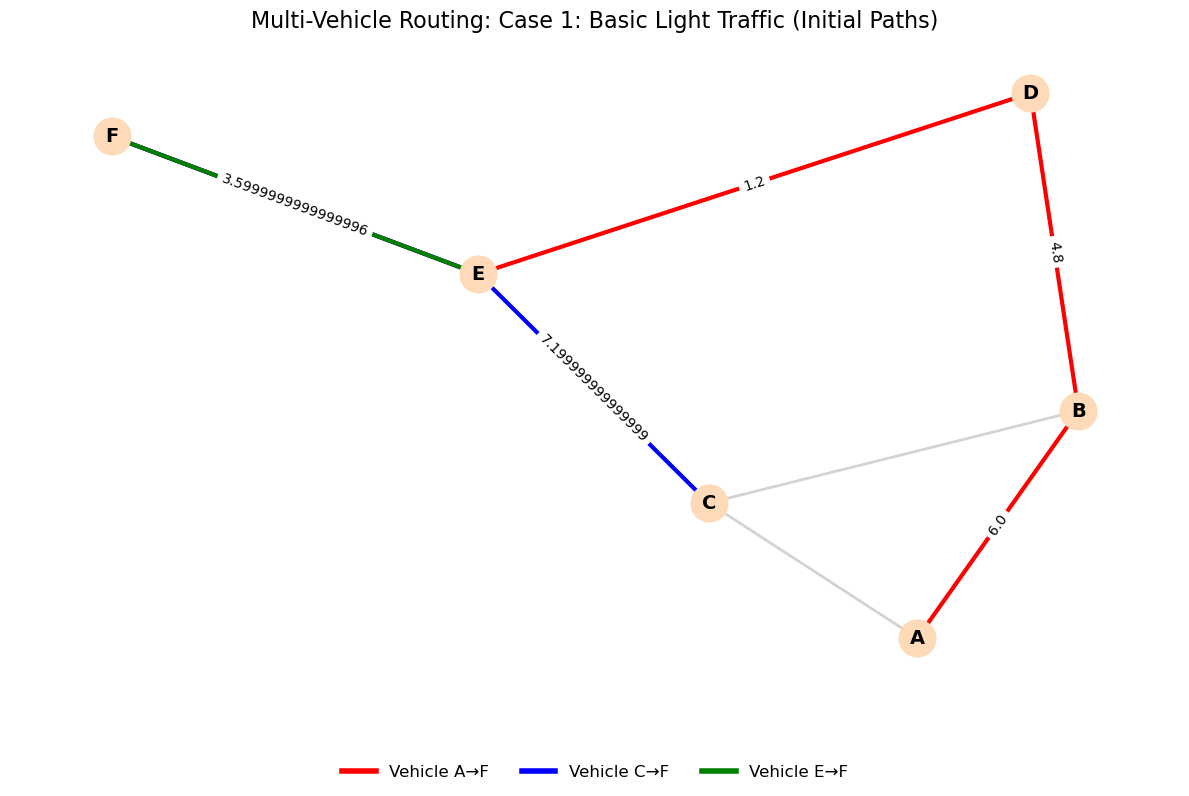


Re-Routed Vehicle Paths After Congestion:
Vehicle A→F: A → B → D → E → F | Cost: 13
Vehicle C→F: C → E → F | Cost: 9.6
Vehicle E→F: E → F | Cost: 3.6


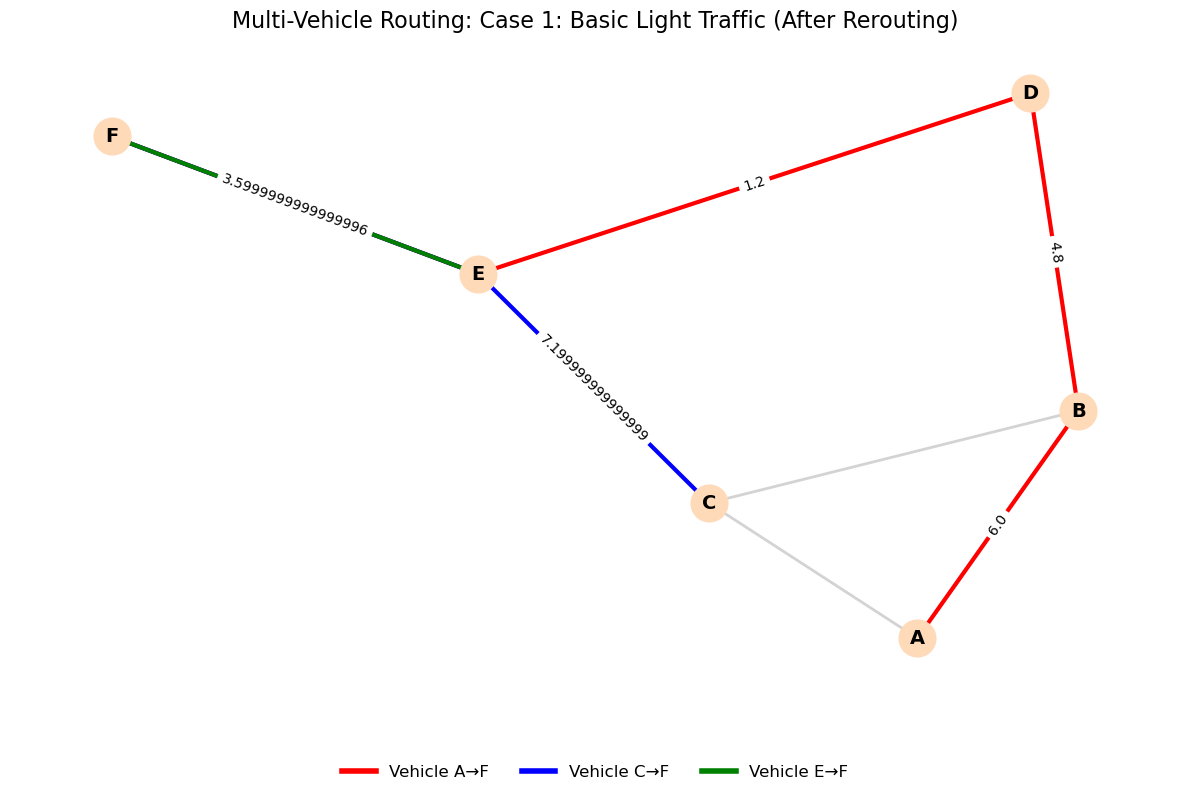


Traffic Light Timings — Case 1: Basic Light Traffic (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → A→B       :  70 seconds green
  → D→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection E:
  → C→E       :  70 seconds green
  → F→E       :  45 seconds green
  → D→E       :   5 seconds green
  Total Cycle Time: 120 

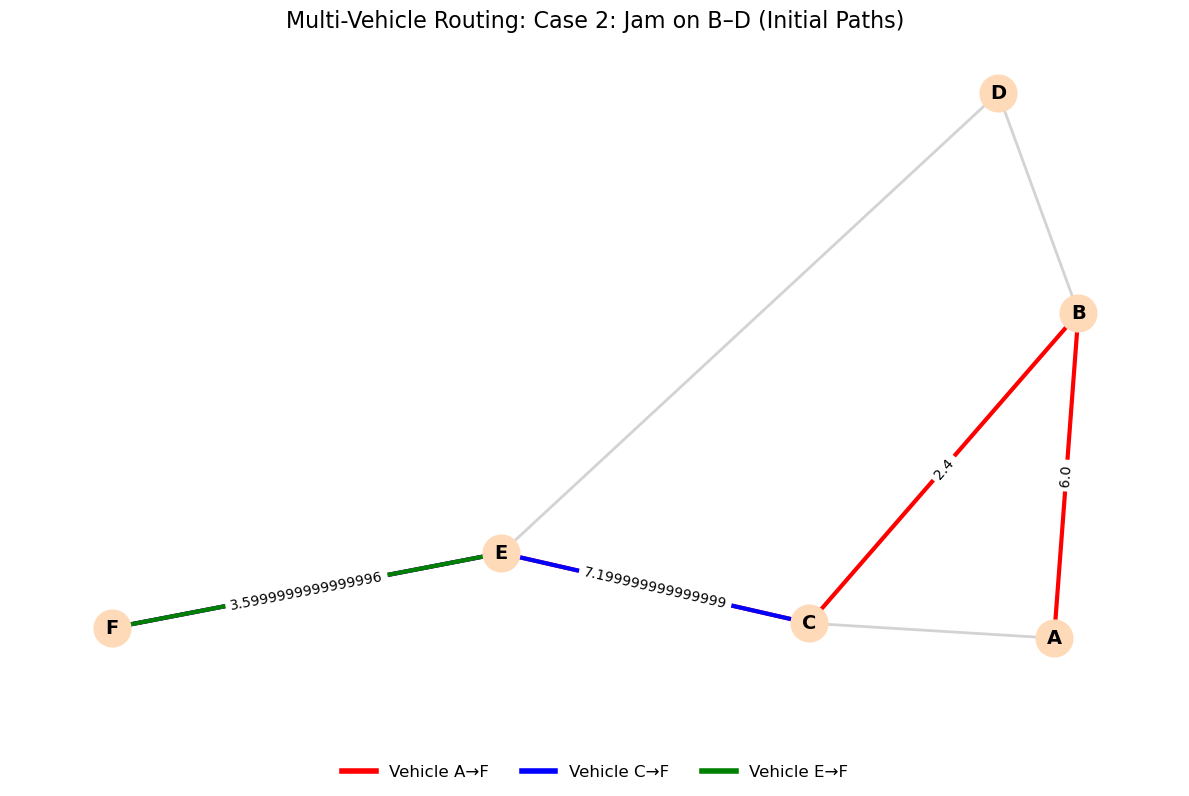


Re-Routed Vehicle Paths After Congestion:
Vehicle A→F: A → B → C → E → F | Cost: 16
Vehicle C→F: C → E → F | Cost: 10.8
Vehicle E→F: E → F | Cost: 3.6


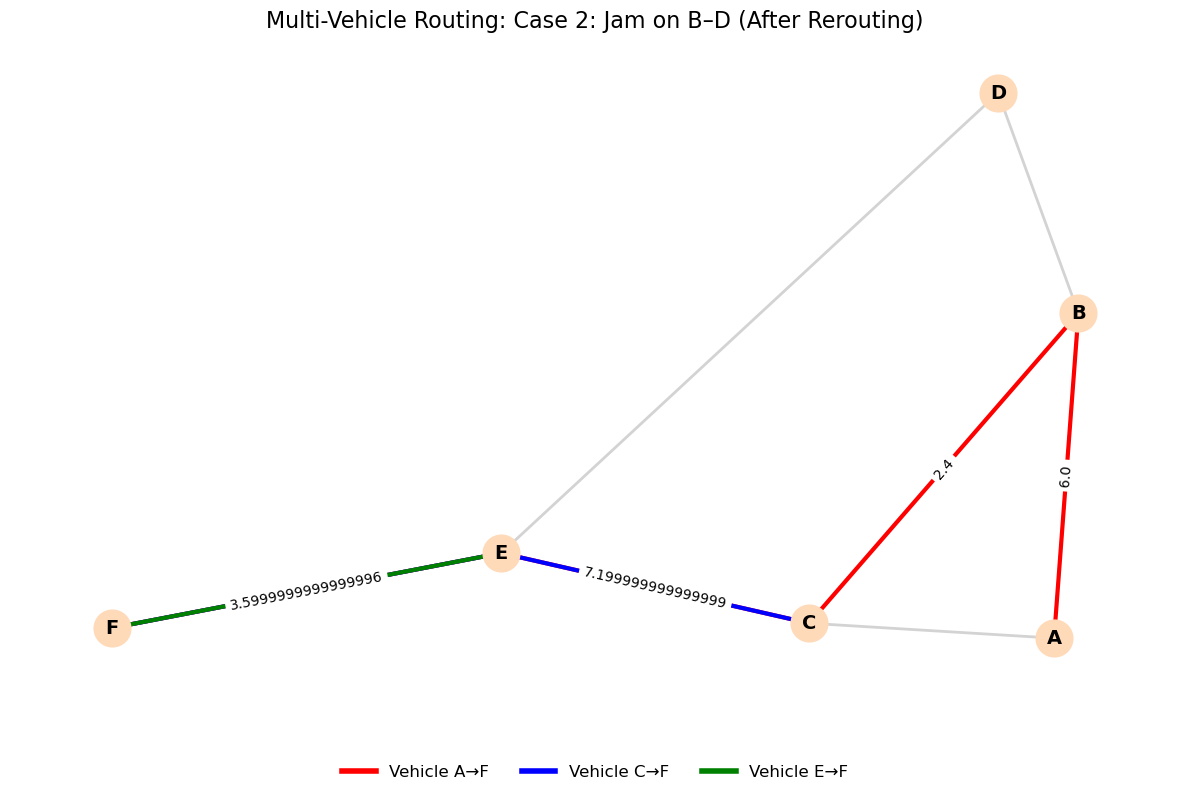


Traffic Light Timings — Case 2: Jam on B–D (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → D→B       :  70 seconds green
  → A→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection E:
  → C→E       :  70 seconds green
  → F→E       :  45 seconds green
  → D→E       :   5 seconds green
  Total Cycle Time: 120 seconds
-

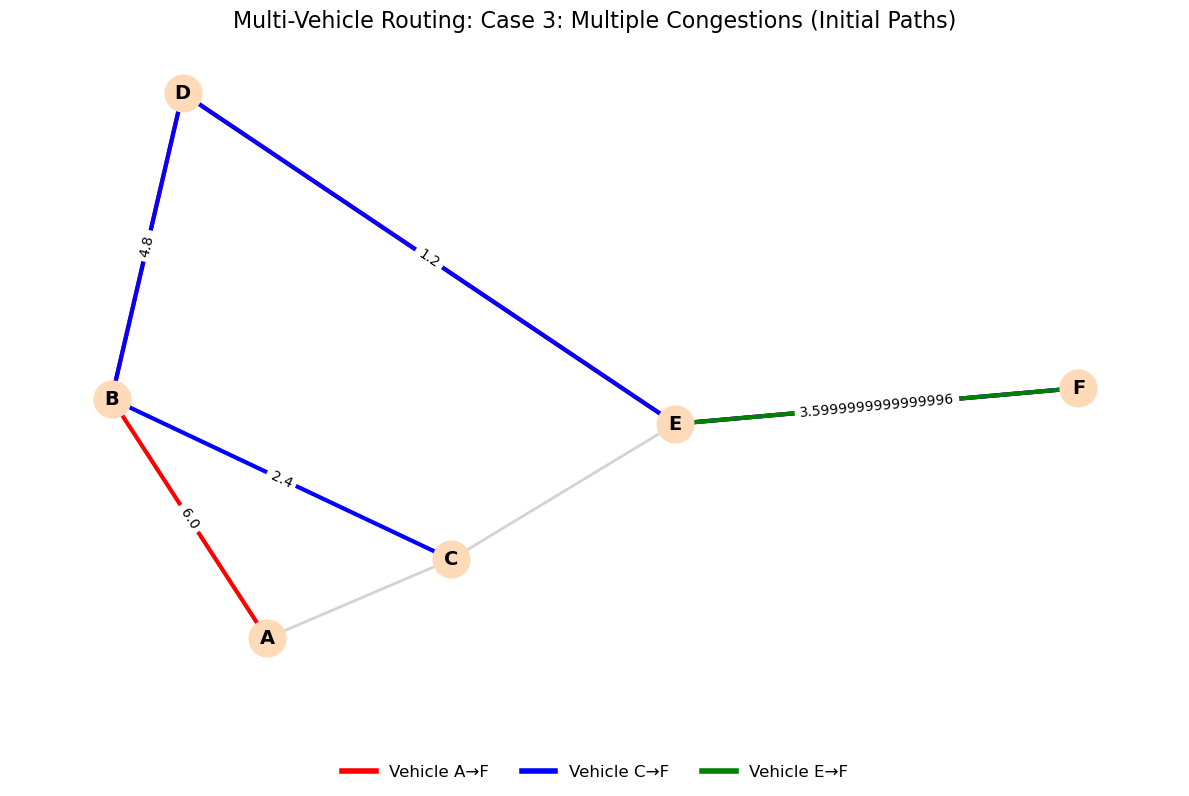


Re-Routed Vehicle Paths After Congestion:
Vehicle A→F: A → B → D → E → F | Cost: 27
Vehicle C→F: C → B → D → E → F | Cost: 11.6
Vehicle E→F: E → F | Cost: 3.6


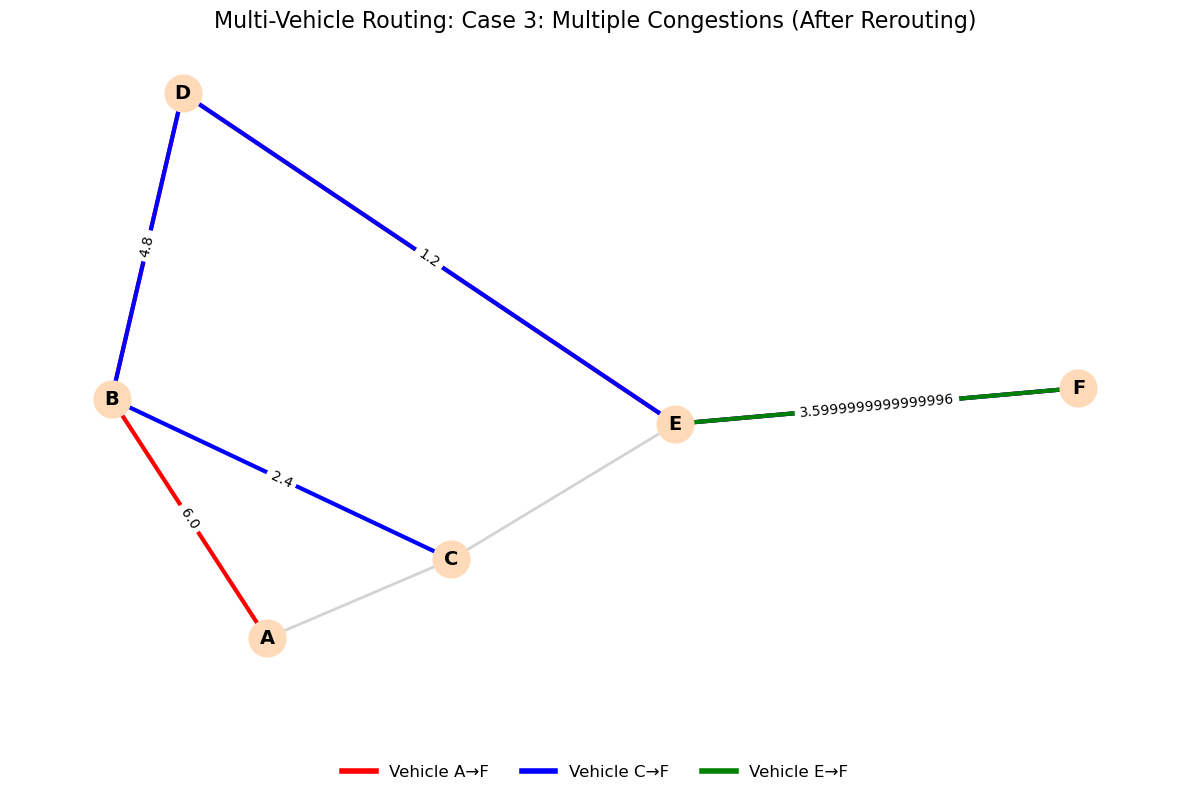


Traffic Light Timings — Case 3: Multiple Congestions (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → A→B       :  70 seconds green
  → D→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection E:
  → C→E       :  70 seconds green
  → F→E       :  45 seconds green
  → D→E       :   5 seconds green
  Total Cycle Time: 120

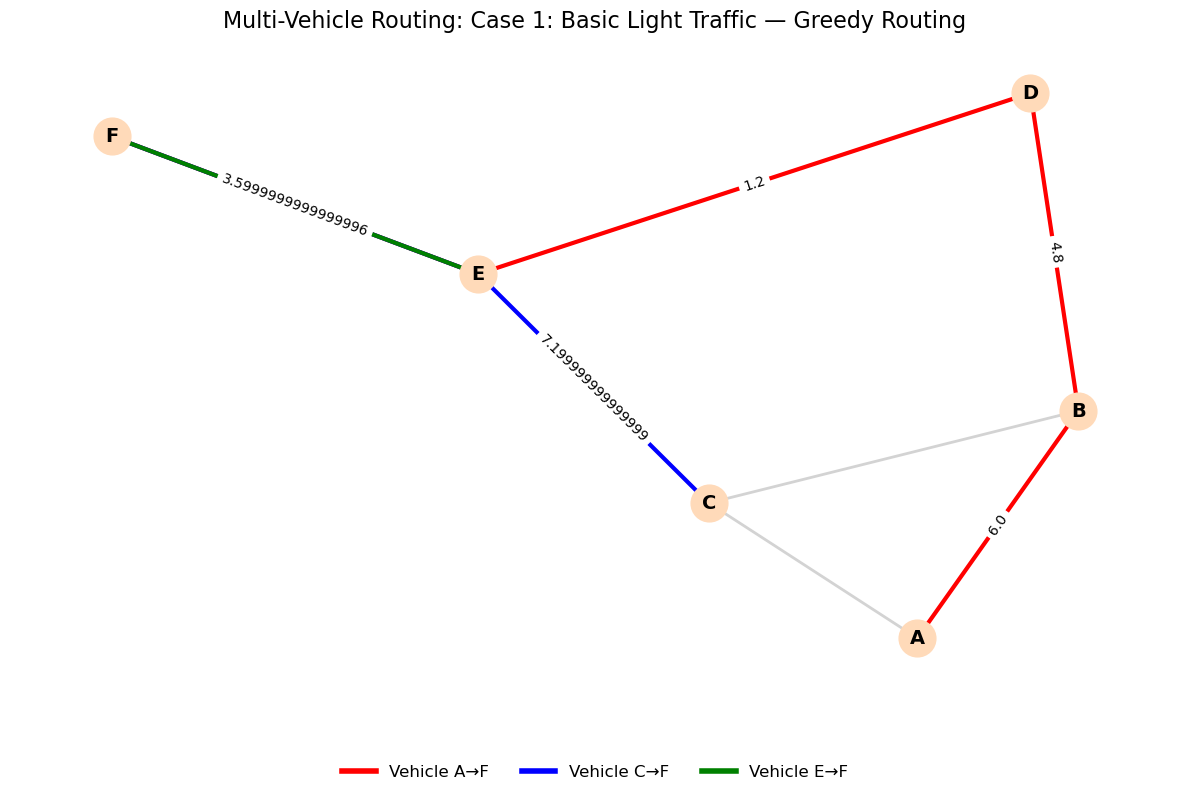


📌 Bottlenecks by Usage:
  Road E–F: used 3 times

📌 Bottlenecks by Congestion Multiplier:

Traffic Light Timings — Case 1: Basic Light Traffic (Greedy Routing) (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → A→B       :  70 seconds green
  → D→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection E:
  → C→E       :  7

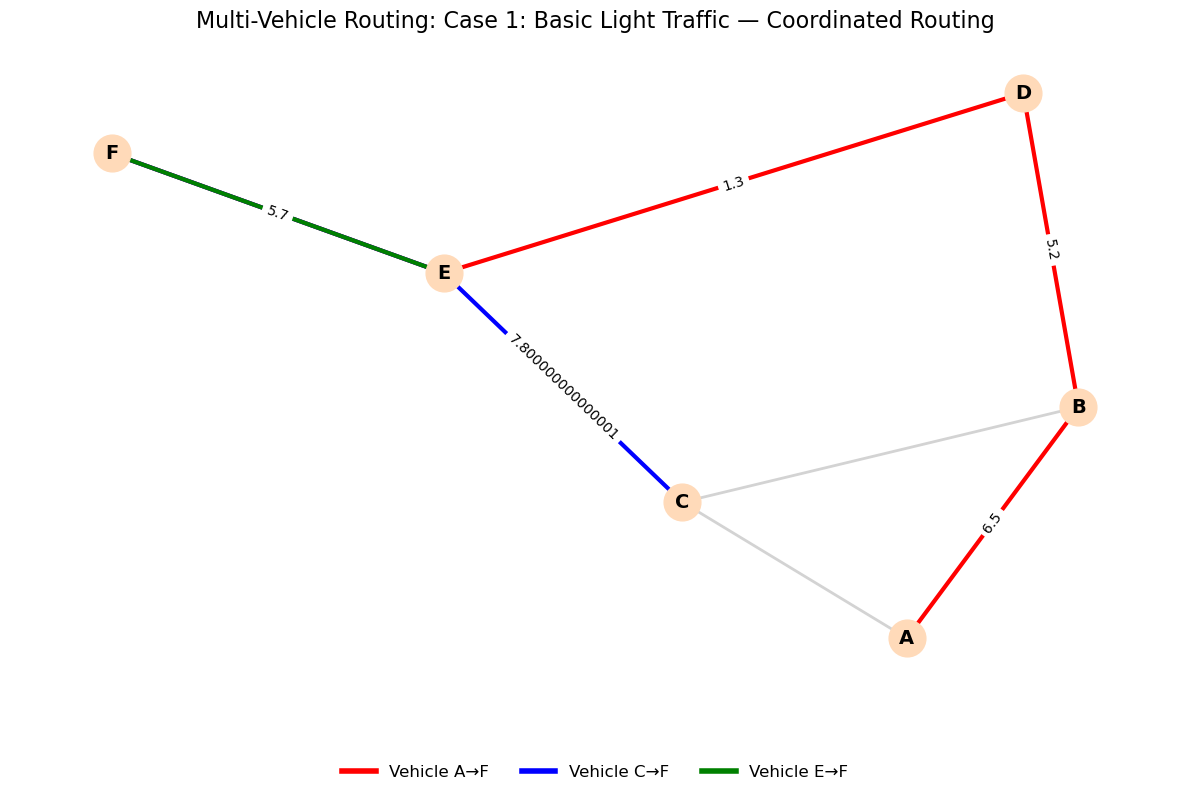


📌 Bottlenecks by Usage:
  Road E–F: used 3 times

📌 Bottlenecks by Congestion Multiplier:

Traffic Light Timings — Case 1: Basic Light Traffic (Coordinated Routing) (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → A→B       :  70 seconds green
  → D→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection E:
  → C→E      

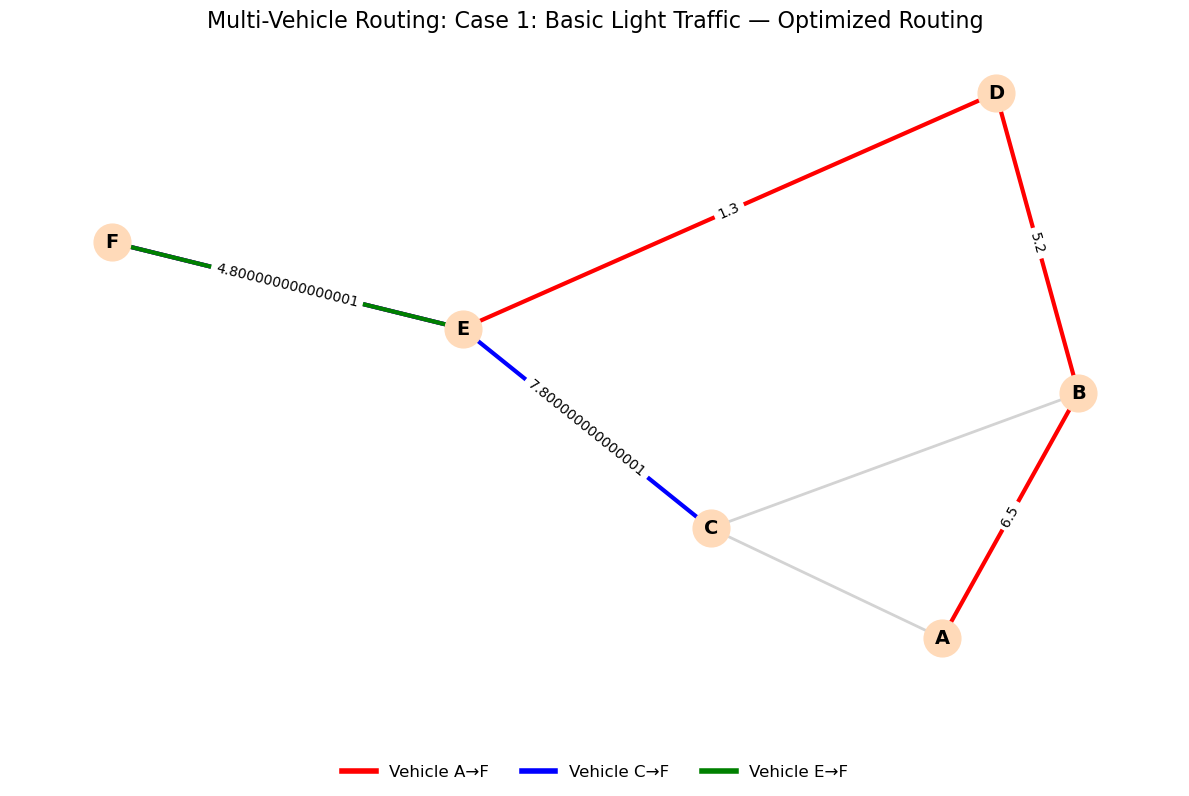


📌 Bottlenecks by Usage:
  Road E–F: used 3 times

📌 Bottlenecks by Congestion Multiplier:

Traffic Light Timings — Case 1: Basic Light Traffic (Optimized Routing) (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → A→B       :  70 seconds green
  → D→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection E:
  → C→E       :

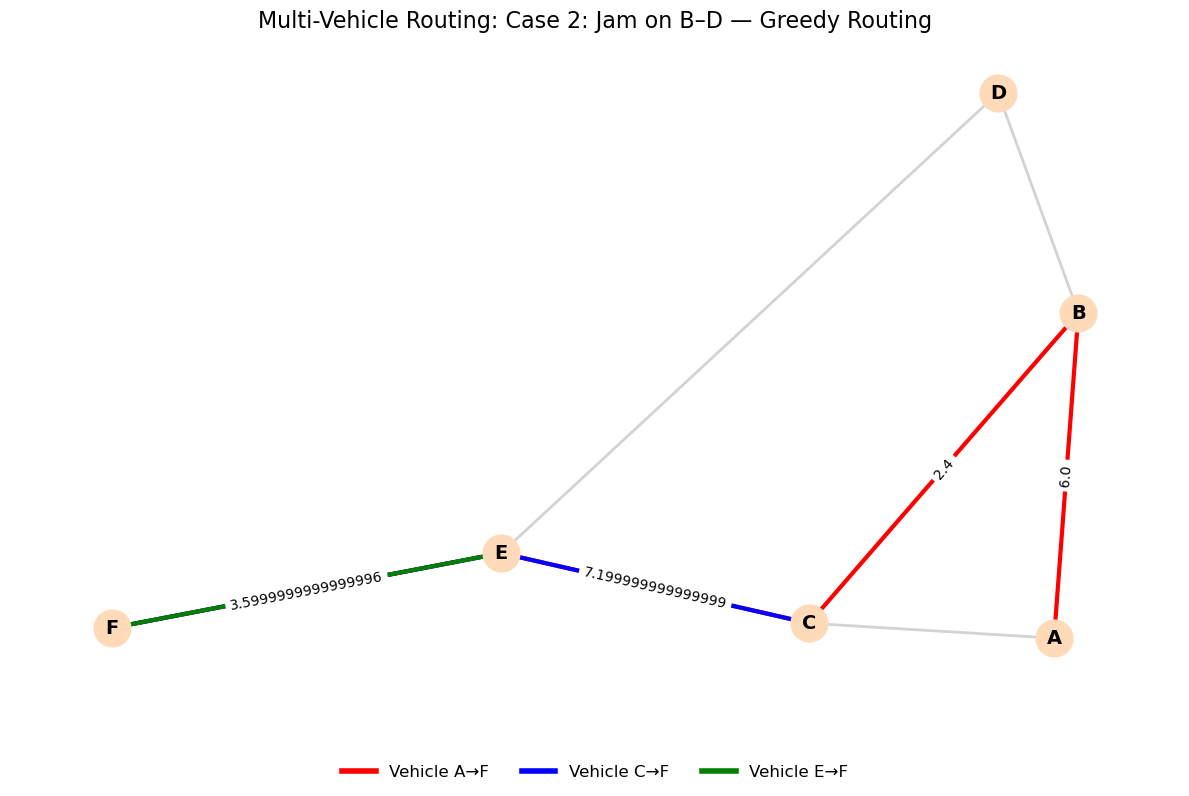


📌 Bottlenecks by Usage:
  Road C–E: used 2 times
  Road E–F: used 3 times

📌 Bottlenecks by Congestion Multiplier:
  Road B–D: multiplier = 4

Traffic Light Timings — Case 2: Jam on B–D (Greedy Routing) (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → D→B       :  70 seconds green
  → A→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------

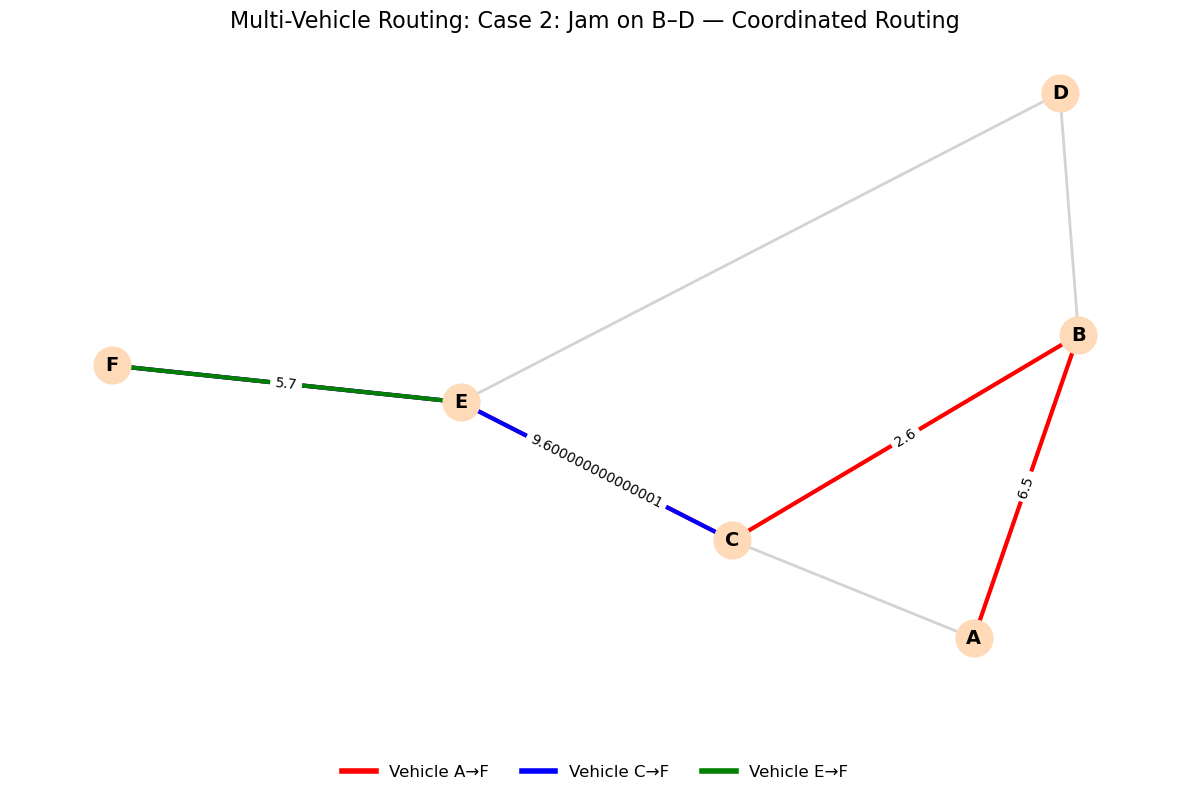


📌 Bottlenecks by Usage:
  Road C–E: used 2 times
  Road E–F: used 3 times

📌 Bottlenecks by Congestion Multiplier:
  Road B–D: multiplier = 4

Traffic Light Timings — Case 2: Jam on B–D (Coordinated Routing) (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → D→B       :  70 seconds green
  → A→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
-------------------------------------------------

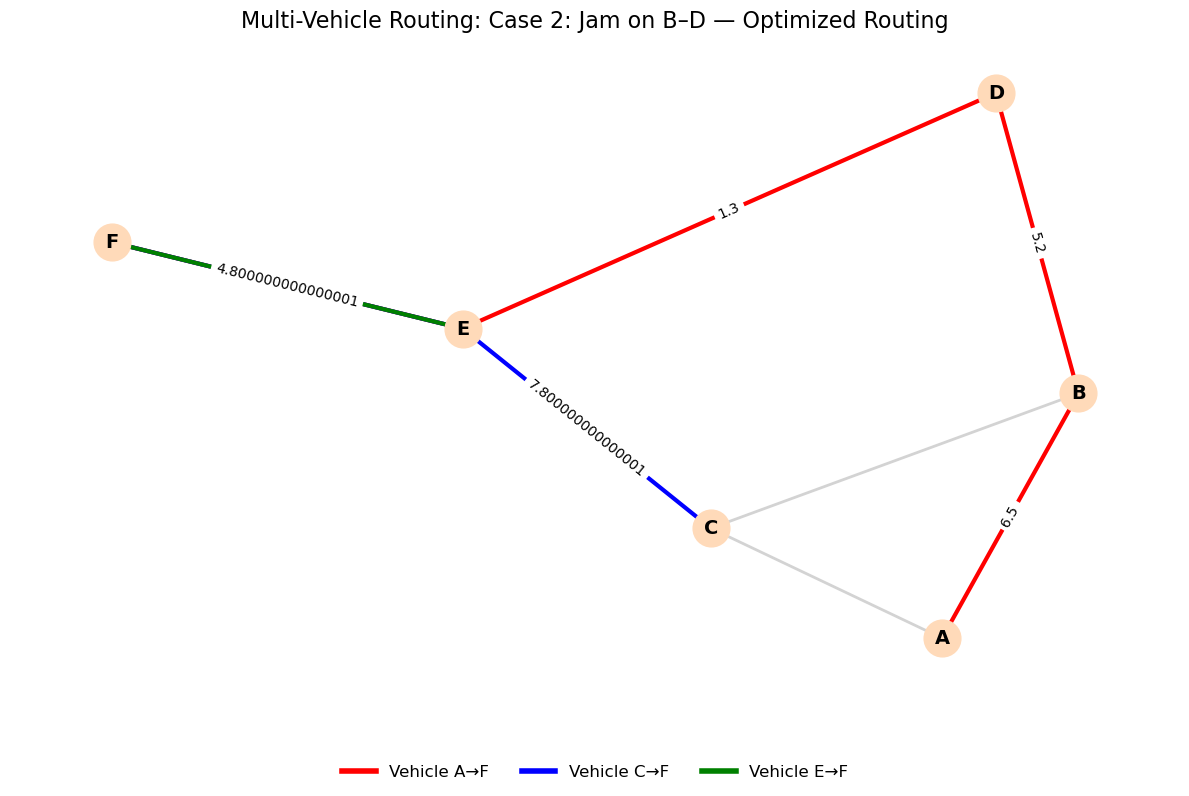


📌 Bottlenecks by Usage:
  Road E–F: used 3 times

📌 Bottlenecks by Congestion Multiplier:
  Road B–D: multiplier = 4

Traffic Light Timings — Case 2: Jam on B–D (Optimized Routing) (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → A→B       :  70 seconds green
  → D→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection 

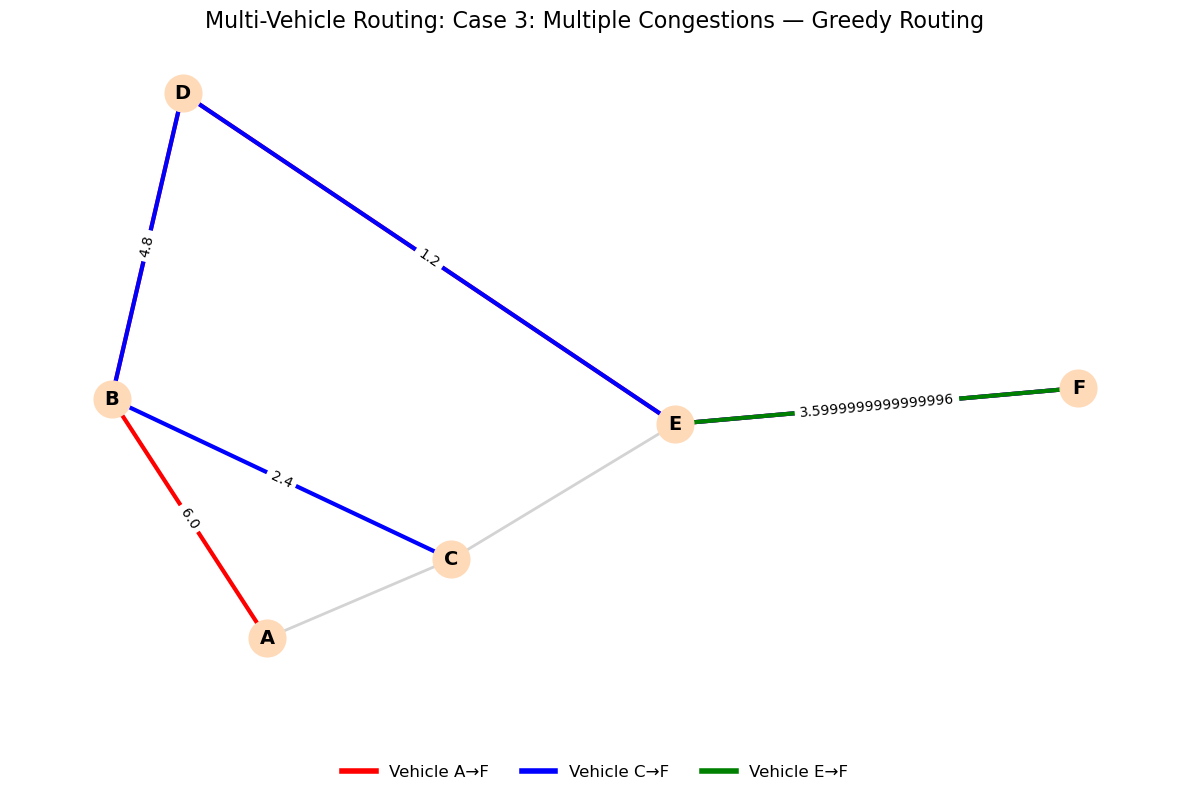


📌 Bottlenecks by Usage:
  Road B–D: used 2 times
  Road D–E: used 2 times
  Road E–F: used 3 times

📌 Bottlenecks by Congestion Multiplier:
  Road A–C: multiplier = 2
  Road C–E: multiplier = 2

Traffic Light Timings — Case 3: Multiple Congestions (Greedy Routing) (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → A→B       :  70 seconds green
  → D→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Time: 120 

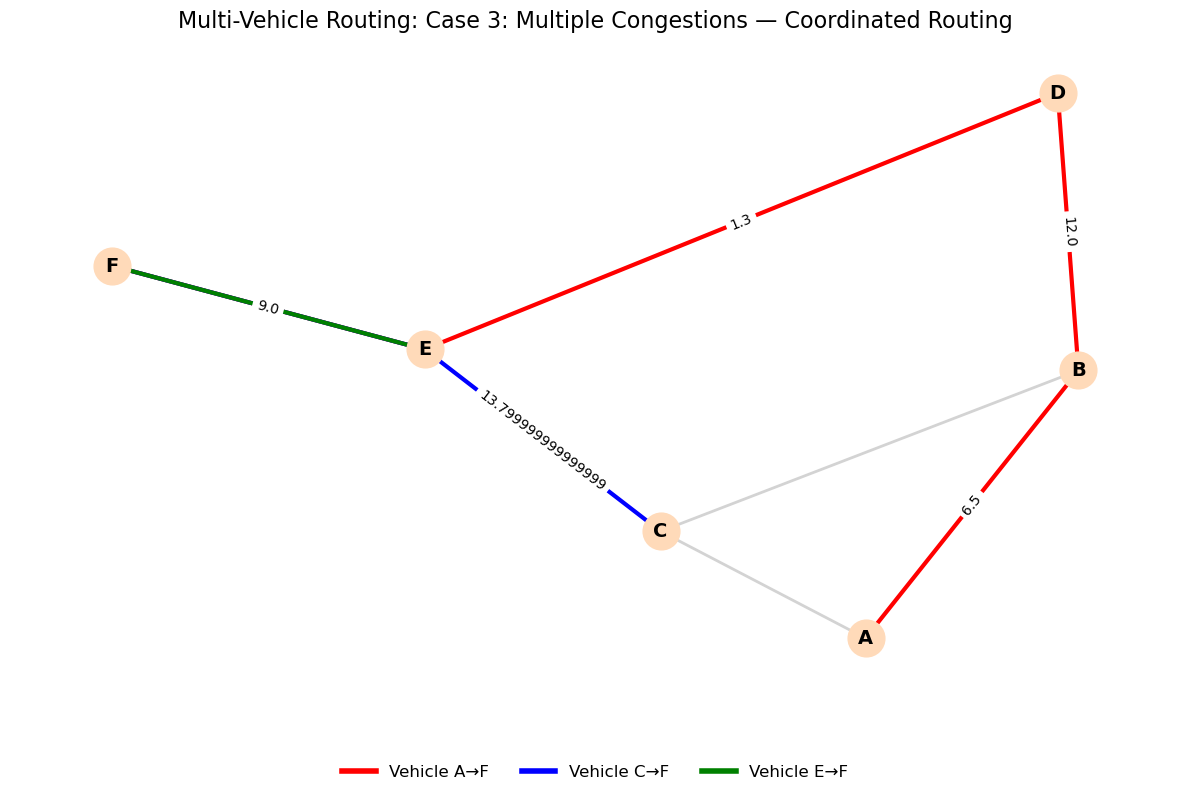


📌 Bottlenecks by Usage:
  Road E–F: used 3 times

📌 Bottlenecks by Congestion Multiplier:
  Road A–C: multiplier = 2
  Road B–D: multiplier = 3.0
  Road C–E: multiplier = 2.3
  Road E–F: multiplier = 3.0

Traffic Light Timings — Case 3: Multiple Congestions (Coordinated Routing) (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → D→B       :  70 seconds green
  → A→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total C

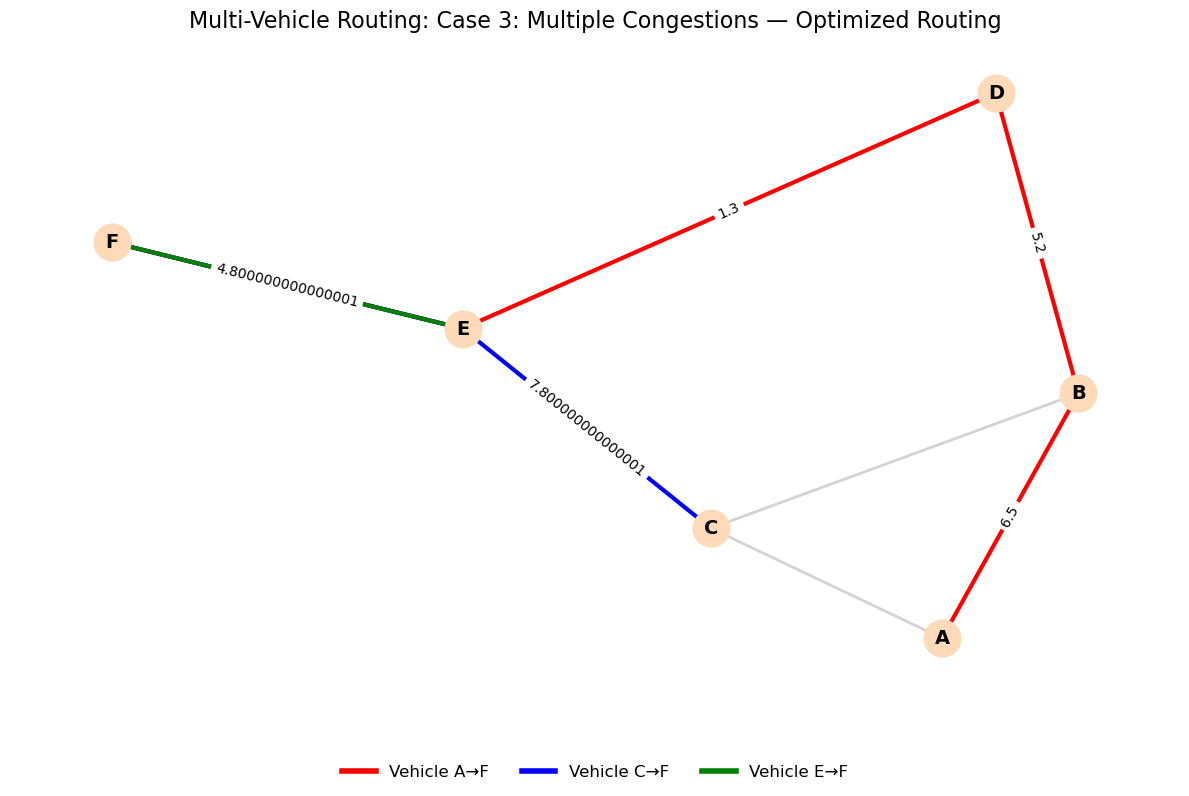


📌 Bottlenecks by Usage:
  Road E–F: used 3 times

📌 Bottlenecks by Congestion Multiplier:
  Road A–C: multiplier = 2
  Road B–D: multiplier = 3
  Road C–E: multiplier = 2
  Road E–F: multiplier = 3

Traffic Light Timings — Case 3: Multiple Congestions (Optimized Routing) (After Congestion)

 Intersection A:
  → C→A       :  70 seconds green
  → B→A       :  50 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection B:
  → A→B       :  70 seconds green
  → D→B       :  45 seconds green
  → C→B       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection C:
  → A→C       :  70 seconds green
  → E→C       :  45 seconds green
  → B→C       :   5 seconds green
  Total Cycle Time: 120 seconds
------------------------------------------------------------

 Intersection D:
  → B→D       :  70 seconds green
  → E→D       :  50 seconds green
  Total Cycle Tim

In [55]:

run_dynamic_cycle("data/traffic_data_case1.csv", "Case 1: Basic Light Traffic")
run_dynamic_cycle("data/traffic_data_case2.csv", "Case 2: Jam on B–D")
run_dynamic_cycle("data/traffic_data_case3.csv", "Case 3: Multiple Congestions")
run_full_comparison("data/traffic_data_case1.csv", "Case 1: Basic Light Traffic")
run_full_comparison("data/traffic_data_case2.csv", "Case 2: Jam on B–D")
run_full_comparison("data/traffic_data_case3.csv", "Case 3: Multiple Congestions")

In [47]:
import os

def ensure_output_folder():
    if not os.path.exists("outputs"):
        os.makedirs("outputs")

In [48]:
def export_vehicle_paths(vehicle_paths, filename):
    ensure_output_folder()
    path = os.path.join("outputs", filename)
    data = []
    for vehicle in vehicle_paths:
        data.append({
            "Vehicle": f"{vehicle['start']}→{vehicle['end']}",
            "Path": " → ".join(vehicle['path']) if vehicle['path'] else "No path",
            "Cost": round(vehicle['cost'], 2)
        })
    df = pd.DataFrame(data)
    df.to_csv(path, index=False)
    print(f" Vehicle paths exported to {path}")

In [49]:
def export_traffic_light_timings(timings, filename):
    ensure_output_folder()
    path = os.path.join("outputs", filename)
    data = []
    for intersection, lights in timings.items():
        for direction, time in lights.items():
            data.append({
                "Intersection": intersection,
                "Direction": direction,
                "Green_Time_Seconds": time
            })
    df = pd.DataFrame(data)
    df.to_csv(path, index=False)
    print(f" Traffic light timings exported to {path}")

In [52]:
def run_and_export(case_csv, case_name, vehicle_starts=["A", "C", "E"], destination="F"):
    print(f"\nExporting Results — {case_name}")
    
    
    G, vehicle_paths = greedy_vehicle_routing(case_csv, vehicle_starts, destination)
    print("→ Vehicle paths calculated")

    safe_name = case_name.replace(" ", "_").replace(":", "")
    export_vehicle_paths(vehicle_paths, filename=f"{safe_name}_paths.csv")

    
    timings = generate_traffic_light_timings(G)
    print("→ Traffic light timings recalculated")
    export_traffic_light_timings(timings, filename=f"{safe_name}_lights.csv")

    # Final visual
    visualize_multi_vehicle_paths(G, vehicle_paths, case_name + " (Final State)")


Exporting Results — Case 1: Basic Light Traffic
→ Vehicle paths calculated
 Vehicle paths exported to outputs\Case_1_Basic_Light_Traffic_paths.csv
→ Traffic light timings recalculated
 Traffic light timings exported to outputs\Case_1_Basic_Light_Traffic_lights.csv


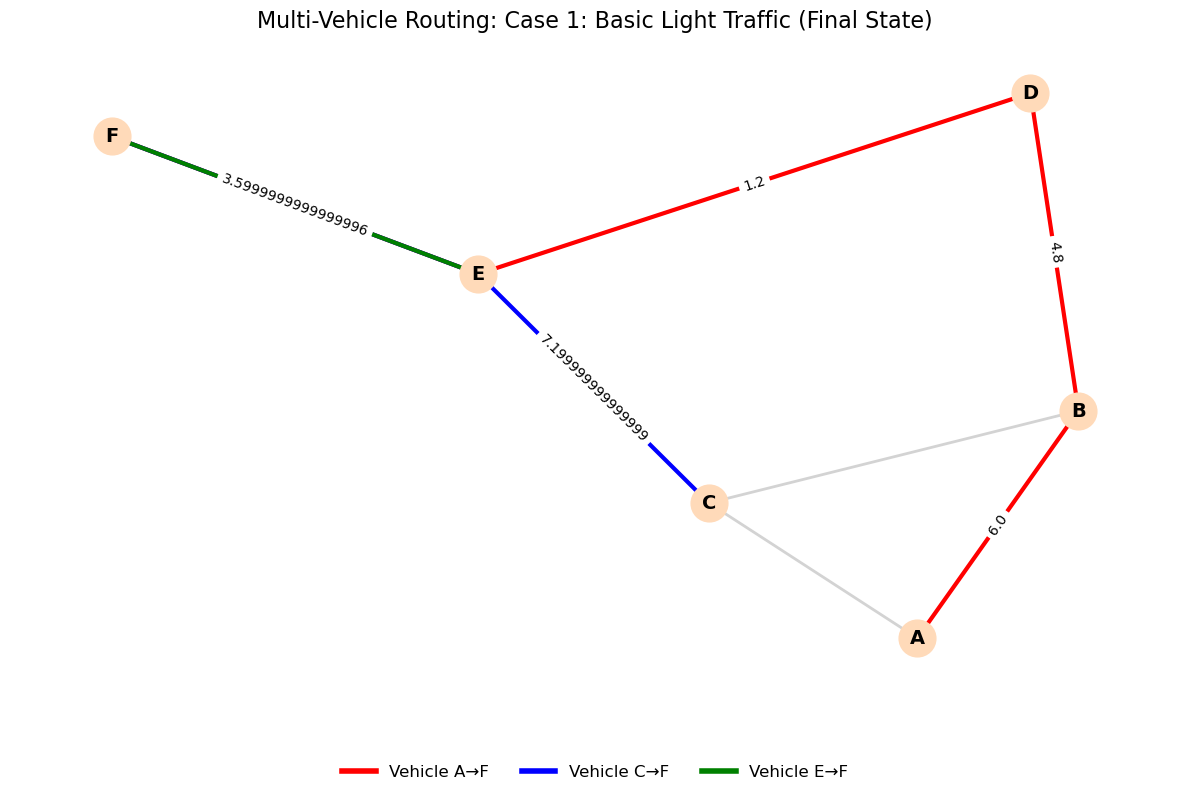


Exporting Results — Case 2: Jam on B–D
→ Vehicle paths calculated
 Vehicle paths exported to outputs\Case_2_Jam_on_B–D_paths.csv
→ Traffic light timings recalculated
 Traffic light timings exported to outputs\Case_2_Jam_on_B–D_lights.csv


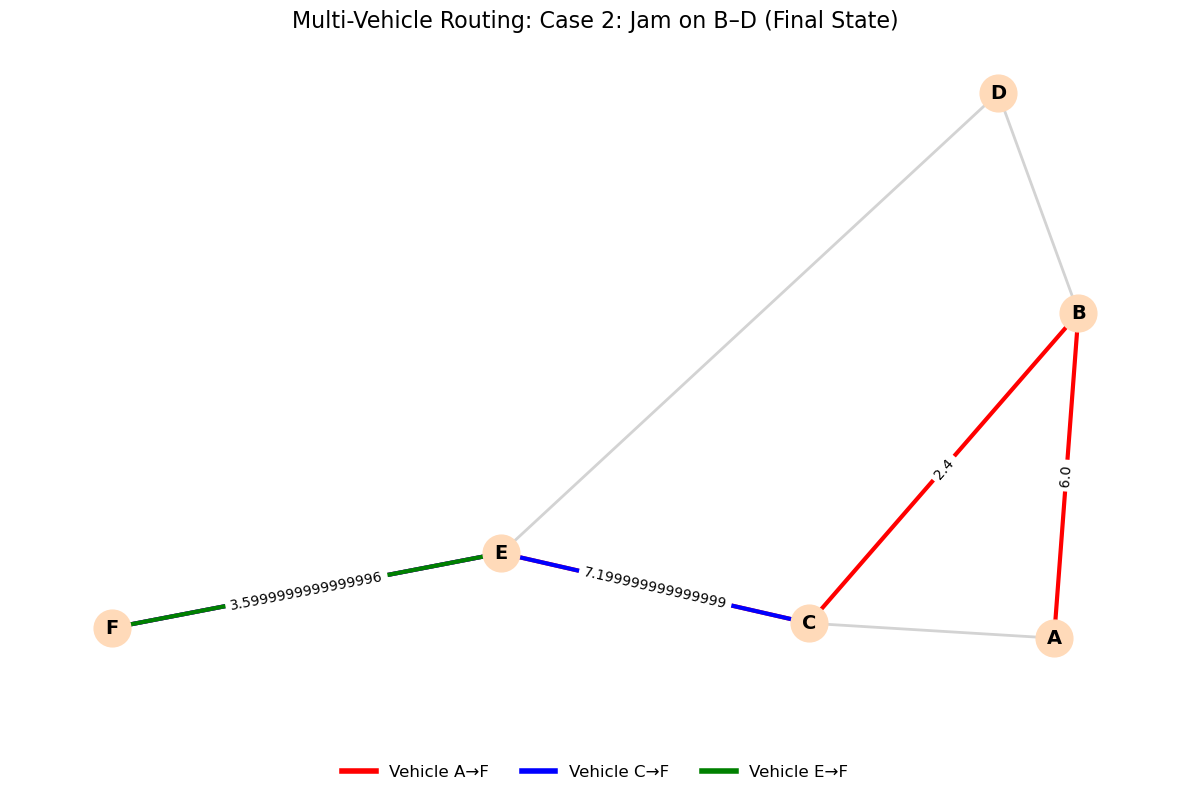


Exporting Results — Case 3: Multiple Congestions
→ Vehicle paths calculated
 Vehicle paths exported to outputs\Case_3_Multiple_Congestions_paths.csv
→ Traffic light timings recalculated
 Traffic light timings exported to outputs\Case_3_Multiple_Congestions_lights.csv


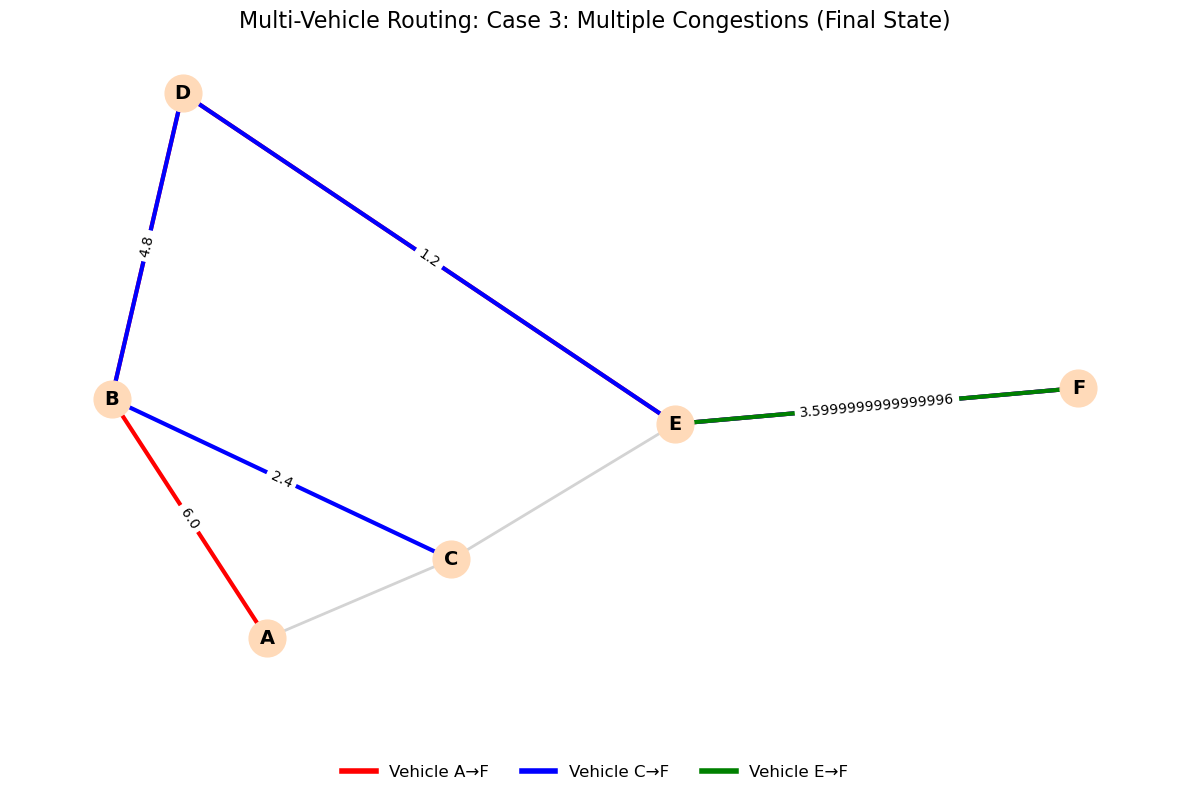

In [51]:
run_and_export("data/traffic_data_case1.csv", "Case 1: Basic Light Traffic")
run_and_export("data/traffic_data_case2.csv", "Case 2: Jam on B–D")
run_and_export("data/traffic_data_case3.csv", "Case 3: Multiple Congestions")